# LSL hands-on:
# What did we learn comparing EEG and Unity data streams?
<br>

### Tea Time 16.04.2020 -  Marc Vidal De Palol

## Outline

1. Why aligning data streams is important?
2. Delay, jitter and latency
3. What is LSL (lab streaming layer)?
4. Designing the test
5. How did we analyze the data?
6. Results
7. Conclusions and remarks
8. Future outlook

## 1. Why aligning data streams is important?

Data streaming devices have different:
- Sampling rates 
- CPU clocks


<img src="img/sines.png" width="40%"><img src="img/cpu.png" width="20%">

- Plus: they can be connected via network (LAN or WLAN) -> delays

## 1. Why aligning data streams is important?

Example:

<img src="img/westdrive.png" width="70%">


## 1. Why aligning data streams is important?

Example:<br>

- Westdrive (Unity): 60 FPS <br>
<img src="img/westdrive.png" width="30%">
- Toby eye tracker: 90 Hz <br>
<img src="img/hmd.png" width="20%">
- TMSI Rega EEG amplifier: 1024 Hz <br>
<img src="img/ant_cap.png" width="20%">

## 2. Delay, latency and jitter

<img alt="ping" src="img/delay.gif" width="40%">

Differences:
- Delay: time for some data to move from one endpoint to another
- Latency: one-way delay
- Jitter: delay inconsistency between each packet

Delay contributors:
- Processing: package analysis time
- Queueing: time between being queued and sent
- Transmission: time to push the data into the wire
- Propagation: time influenced by the distance

Source: https://www.callstats.io/blog/2018/03/07/difference-between-jitter-and-latency

## 3. What is LSL (lab streaming layer)?

Two ways of solving the alignment of time series data:
- manually-> more time consuming, but more control
- automatically via soft solution (e.g. LSL) -> less time consuming, less control

Also advantages of LSL:
- open source
- cross platform (Win, Linux, MacOS, Android, iOS)
- multi API language interfaces (C, C++, Python, Java, C#, MATLAB)
- many tools around it
- scientific community support
- XDF stored data

Source: https://labstreaminglayer.readthedocs.io/info/intro.html#what-is-lsl

## 3. What is LSL (lab streaming layer)?

How to use LSL? Requirements:
- LabRecorder app
- liblsl library with code defining your data streams

    and/or

- LSL community app

## 3. What is LSL (lab streaming layer)?

The Lab Recorder (with BIDS support):


<img src="img/labrecorder.png" width="80%">

## 3. What is LSL (lab streaming layer)?

Code example in C# defining a data stream:
```csharp
using LSL;

public class yourClass
{
    private liblsl.StreamInfo lslStreamInfo;
    private liblsl.StreamOutlet lslOutlet;

    void startingMethod() { // normally Start() in Unity
        lslStreamInfo = new liblsl.StreamInfo(
            sName,
            sType,
            nValues,
            nominalRate,
            LslChannelFormat,
            uuid);
        lslOutlet = new liblsl.StreamOutlet(streamInfo);
    }

    void sendingMethod() { // normally FixedUpdate() in Unity
        var data = new float[size];
        lslOutlet.push_sample(data);
    }
}
```

## 4. Designing the test

Situation: Every 500ms a beep sound is played and the background color changes one frame from black to white.

Unity (90 FPS):
- color change (black or white background)
- 100 ms beep sound (audio playing or not)

EEG (1024 Hz):
- photodiode (light sensor)
- microphone (audio sensor)

Recording setups with different:
- HMDs (Head-mounted display)
- computers (single and two LAN-connected)
- Unity builds
- long and short recordings

## 4. Designing the test

<img src="img/test_design.png" width="85%">

## 4. Designing the test

Computers specs:

| | CPU | GPU | RAM |
| - | --- | --- | --- |
| __westbrook__ | Intel Xeon E5-1607 v4 (4) @ 3.10GHz | NVIDIA GeForce GTX 1070 | 32GB |
| __VR5__ | Intel Xeon E5-1630 v3 (8) @ 3.80GHz | NVIDIA GeForce GTX 1080 Ti | 32GB |
| __wd-right__ | Intel Xeon W-2133 (12) @ 3.60GHz | NVIDIA GeForce GTX 1080 Ti | 16GB |
<center>
<img src="img/specs.png" width="60%">
</center>

## 4. Designing the test
Background:


<img src="img/background.gif" width="20%">

Audio:

<img src="img/wave.png" width="80%">

## 4. Designing the test
Extra:

<img src="img/editor.png" width="35%">

## 5. How did we analyze the data?

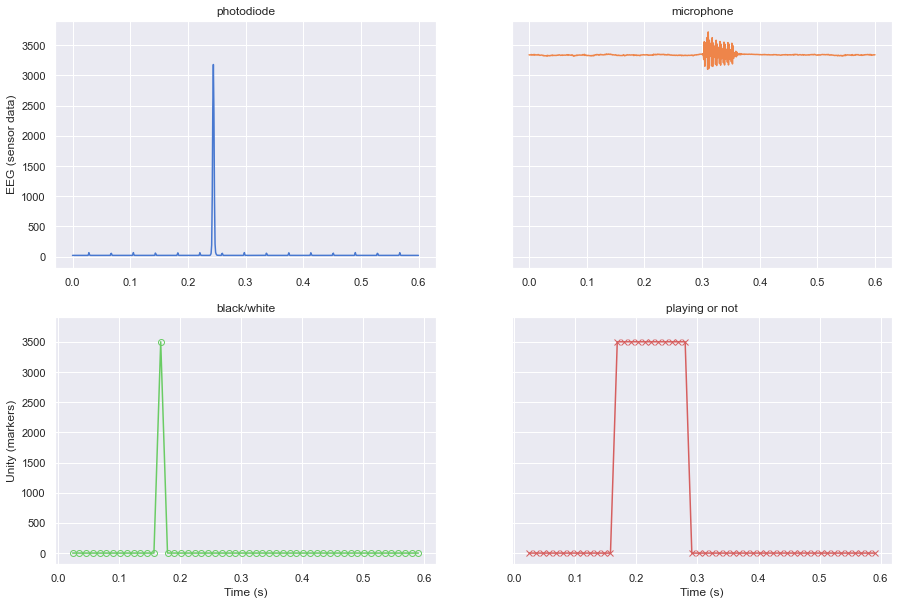

In [80]:
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))

f_n = -0.1  # starting point (s)
s_n = 0.6  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

file = recordings[0]["file"].split(".")[0]
e = copy.deepcopy(recordings[0]["eeg"])
u = copy.deepcopy(recordings[0]["unity"])
e_t = e["timestamps"]
u_t = u["timestamps"]
e_a = e["audio"]
e_c = e["color"]
u_c = u["color"]
u_a = u["audio"]

# fix diff array sizes for unity color and audio arrays
u_diff = len(u_c) - len(u_t)
if u_diff > 0:
    # remove the diff from the end of the array
    u_c = u_c[:-u_diff]
elif u_diff < 0:
    # add the diff from the end of the array
    for i in range(abs(u_diff)):
        u_c = np.append(u_c, u_c[-1])

# select range of timestamps, diode and microphone values (eeg)
e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

# select range of timestamps, color and audio values (unity)
u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]
preview = [
    ["black/white", u_time_selection, u_color_selection * u_height],
    ["playing or not", u_time_selection, u_audio_selection * u_height],
    ["photodiode", e_time_selection, e_color_selection * 0.05],
    ["microphone", e_time_selection, e_audio_selection * 1.5],
]

# plot the selected range to compare eeg vs unity values
nplots = 4  # number of subplots

# define subplots
fig, axes = plt.subplots(nrows=2, ncols=int(nplots / 2), figsize=(15, 10), sharey=True)

axes[0, 0].plot(preview[2][1], preview[2][2], color=next(palette))
axes[0, 0].set_title(preview[2][0])
axes[0, 1].plot(preview[3][1], preview[3][2], color=next(palette))
axes[0, 1].set_title(preview[3][0])
axes[1, 0].plot(
    preview[0][1],
    preview[0][2],
    marker="o",
    color=next(palette),
    markerfacecolor="None",
)
axes[1, 0].set_title(preview[0][0])
axes[1, 1].plot(preview[1][1], preview[1][2], marker="x", color=next(palette))
axes[1, 1].set_title(preview[1][0])

for ax in axes[1, :]:
    ax.set_xlabel("Time (s)")  # set x-axis label
axes[0, 0].set_ylabel("EEG (sensor data)")  # set y-axis label
axes[1, 0].set_ylabel("Unity (markers)")  # set y-axis label
plt.show()

## 5. How did we analyze the data?
<img src="img/plot0.png" width="85%">

1. Read the XDF files and select the right data
    - Unity timestamps
    - Black/White and notPlaying/isPlaying
    - EEG timestamps
    - Photodiode and microphone values
2. Recalculated the timestamps from 0
3. Visualized the data
4. Timestamps comparison (length, duration, sample count...): file info vs original vs calculated
5. Descriptive statistics of timestamps distributions
6. Peak detections and latency calculations

## 6. Results
How the recordings look like?

In [10]:
display(
    checks.drop(
        columns=["eeg_first", "eeg_last", "unity_first", "unity_last", "length_eeg_audio", "length_eeg_color"]
    ).style.applymap(color_checks)
)

,eeg_starts,length_unity_audio,length_unity_color,lsl_aligned,two_computers,computers,duration (')
ftest1,✔,✔,✔,✔,✗,westbrook,2.03
ftest_build1,✔,✔,✔,✔,✗,westbrook,2.08
ftest_lsl12,✔,✔,✔,✗,✗,westbrook,2.21
ftest_build2,✔,✔,✔,✔,✗,westbrook,2.23
ftest3,✔,✔,✔,✔,✗,westbrook,2.28
ftest2,✔,✔,✔,✔,✗,westbrook,2.31
ftest_build3,✔,✔,✔,✔,✗,westbrook,2.43
long2,✔,✔,✔,✔,✔,westbrook & VR5,30.05
long3,✗,✔,✔,✔,✔,westbrook & VR5,30.81
long4,✔,✔,✗,✔,✔,westbrook & VR5,35.68


## 6. Results
How the recordings look like?

- 4 long recordings (3x 30 minutes + 1x 1 hour)
- 6 short recordings (6x 2 minutes, 2 different unity builds)
- ftest_lsl12 removed from the analysis because timestamps were not aligned

## 6. Results
LSL timestamps: aligned vs not aligned

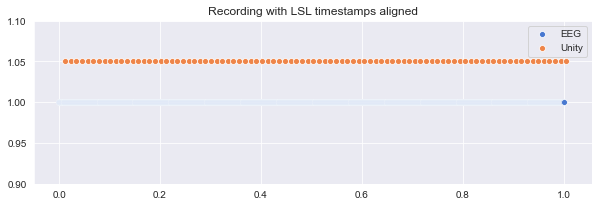

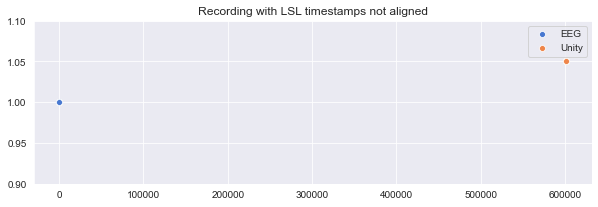

In [11]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 3))
plt.title("Recording with LSL timestamps aligned")
ey = [1 for d in recordings[6]["eeg"]["timestamps"][:1024]]
uy = [1.05 for d in recordings[6]["unity"]["timestamps"][:90]]
sns.scatterplot(x=recordings[6]["eeg"]["timestamps"][:1024], y=ey, color=next(palette))
sns.scatterplot(x=recordings[6]["unity"]["timestamps"][:90], y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.show()
for k in recordings:
    if recordings[k]["file"].split(".")[0] == "ftest_lsl12":
        wrong = k
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 3))
plt.title("Recording with LSL timestamps not aligned")
ey = [1 for d in recordings[wrong]["eeg"]["timestamps"][:1024]]
uy = [1.05 for d in recordings[wrong]["unity"]["timestamps"][:90]]
sns.scatterplot(
    x=recordings[wrong]["eeg"]["timestamps"][:1024], y=ey, color=next(palette)
)
sns.scatterplot(
    x=recordings[wrong]["unity"]["timestamps"][:90], y=uy, color=next(palette)
)
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.show()

## 6. Results
How does the start of `long3` look like?

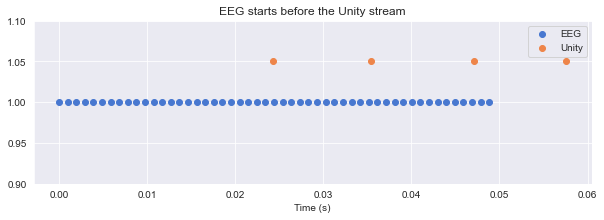

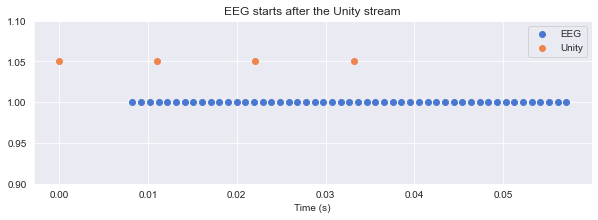

In [13]:
%matplotlib inline
sns.set_style("darkgrid")  # set seaborn plotting style
plt.figure(figsize=(10, 3))
plt.title("EEG starts before the Unity stream")
palette = itertools.cycle(sns.color_palette(palette="muted"))
ey = [1 for d in recordings[9]["eeg"]["timestamps"][:51]]
uy = [1.05 for d in recordings[9]["unity"]["timestamps"][:4]]
plt.scatter(x=recordings[9]["eeg"]["timestamps"][:51], y=ey, color=next(palette))
plt.scatter(x=recordings[9]["unity"]["timestamps"][:4], y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.xlabel("Time (s)")
plt.show()

for k in recordings:
    if not recordings[k]["eeg_starts"]:
        wrong = k

plt.figure(figsize=(10, 3))
plt.title("EEG starts after the Unity stream")
palette = itertools.cycle(sns.color_palette(palette="muted"))
ey = [1 for d in recordings[wrong]["eeg"]["timestamps"][:51]]
uy = [1.05 for d in recordings[wrong]["unity"]["timestamps"][:4]]
plt.scatter(x=recordings[wrong]["eeg"]["timestamps"][:51], y=ey, color=next(palette))
plt.scatter(x=recordings[wrong]["unity"]["timestamps"][:4], y=uy, color=next(palette))
plt.ylim(0.9, 1.1)
plt.legend(["EEG", "Unity"])
plt.xlabel("Time (s)")
plt.show()

## 6. Results
Start and end time differences

In [38]:
display(
    diffs.loc[["Start diff (O)", "End diff (O)"], :].style.applymap(
        color_checks, subset=["AVG"]
    )
)

,ftest1,ftest_build1,ftest_build2,ftest3,ftest2,ftest_build3,long2,long3,long4,final_test,AVG
Start diff (O),0.005823,0.027259,0.021995,0.010033,0.010600,0.012243,0.025177,-0.008265,0.006333,0.024286,0.013548
End diff (O),0.026226,0.504958,0.013666,0.029413,0.029281,-0.472871,0.008625,0.010634,0.009878,0.002887,0.016270


## 6. Results
How constant are the framerates?

__EEG (1024 Hz or sample each ~ 0.98 ms)__

In [18]:
display(e_stats.style.applymap(color_checks, subset=["AVG"]))

,ftest1,ftest_build1,ftest_build2,ftest3,ftest2,ftest_build3,long2,long3,long4,final_test,AVG
count,124959.000000,128031.000000,137247.000000,139807.000000,141855.000000,148511.000000,1846271.000000,1892831.000000,2191839.000000,4042655.000000,1079400.600000
mean,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
25%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
50%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
75%,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977
max,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977,0.000977


## 6. Results
How constant are the framerates?

__EEG (1024 Hz or sample each ~ 0.98 ms)__

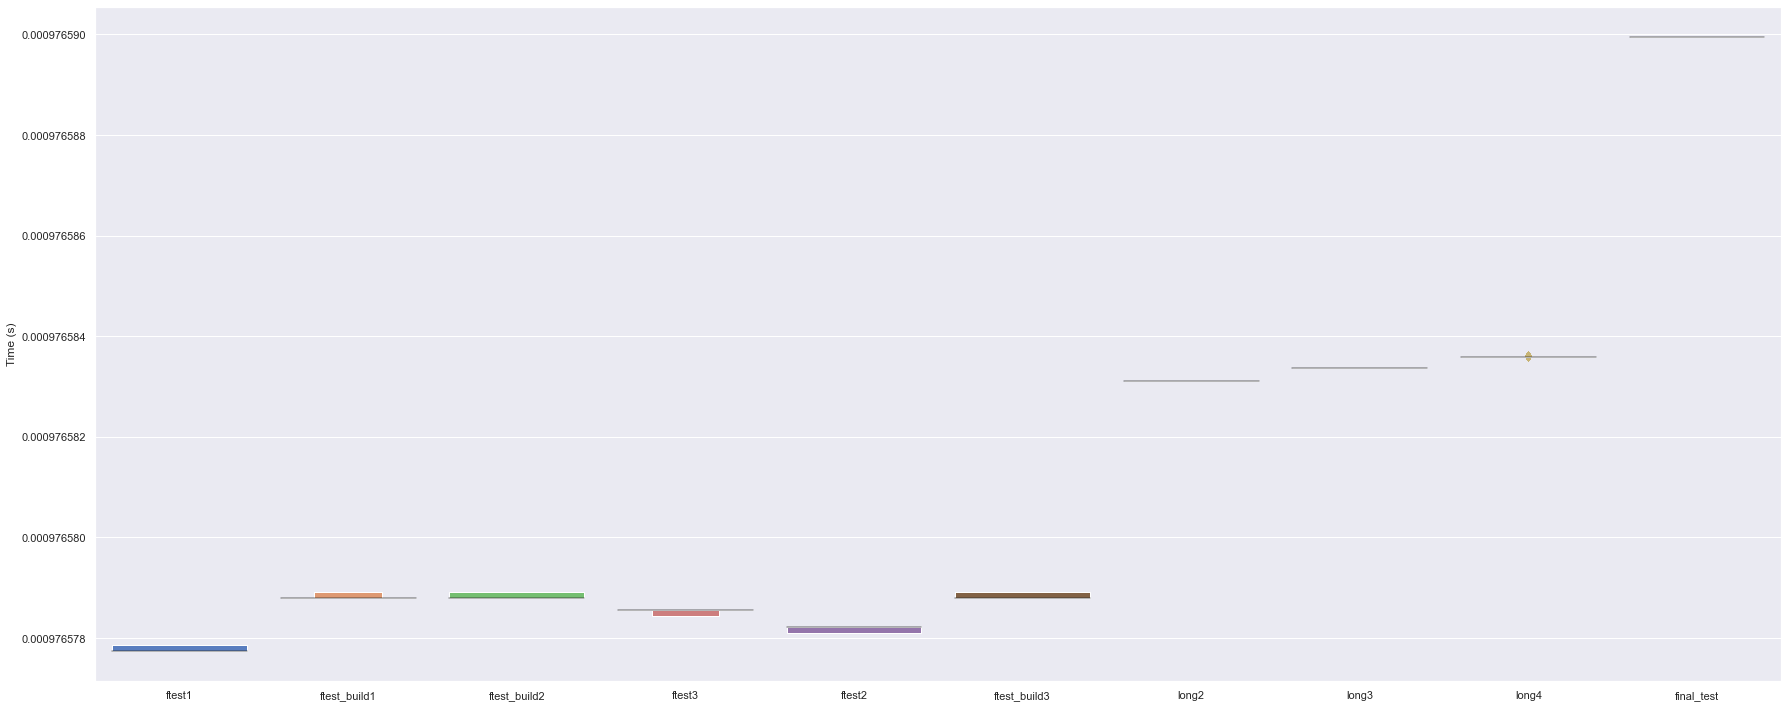

In [19]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.boxenplot(data=e_dist, palette="muted")
g.set_xticklabels(fnames)
plt.ticklabel_format(style="plain", axis="y", useOffset=False)
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()

## 6. Results
How constant are the framerates?

__Unity (90 FPS or sample ~ 11.11 ms)__

In [17]:
display(u_stats.style.applymap(color_checks, subset=["AVG"]))

,ftest1,ftest_build1,ftest_build2,ftest3,ftest2,ftest_build3,long2,long3,long4,final_test,AVG
count,10981.000000,11206.000000,12061.000000,12285.000000,12465.000000,13096.000000,162286.000000,166381.000000,192663.000000,355351.000000,94877.500000
mean,0.011110,0.011110,0.011110,0.011111,0.011111,0.011110,0.011110,0.011110,0.011110,0.011110,0.011110
std,0.001141,0.001266,0.001182,0.001209,0.001135,0.001251,0.000844,0.000840,0.000843,0.000912,0.001062
min,0.000023,0.000023,0.000023,0.000023,0.000023,0.000024,0.000022,0.000022,0.000021,0.000022,0.000023
25%,0.011022,0.011026,0.011020,0.011023,0.011022,0.011019,0.011065,0.011065,0.011069,0.011059,0.011039
50%,0.011109,0.011110,0.011111,0.011110,0.011108,0.011111,0.011106,0.011106,0.011106,0.011107,0.011108
75%,0.011195,0.011194,0.011198,0.011194,0.011196,0.011202,0.011148,0.011148,0.011143,0.011155,0.011178
max,0.022469,0.022343,0.022632,0.022717,0.022827,0.025182,0.023186,0.023030,0.023148,0.022965,0.023050


## 6. Results
How constant are the framerates?

__Unity (90 FPS or sample each 11.11 ms)__

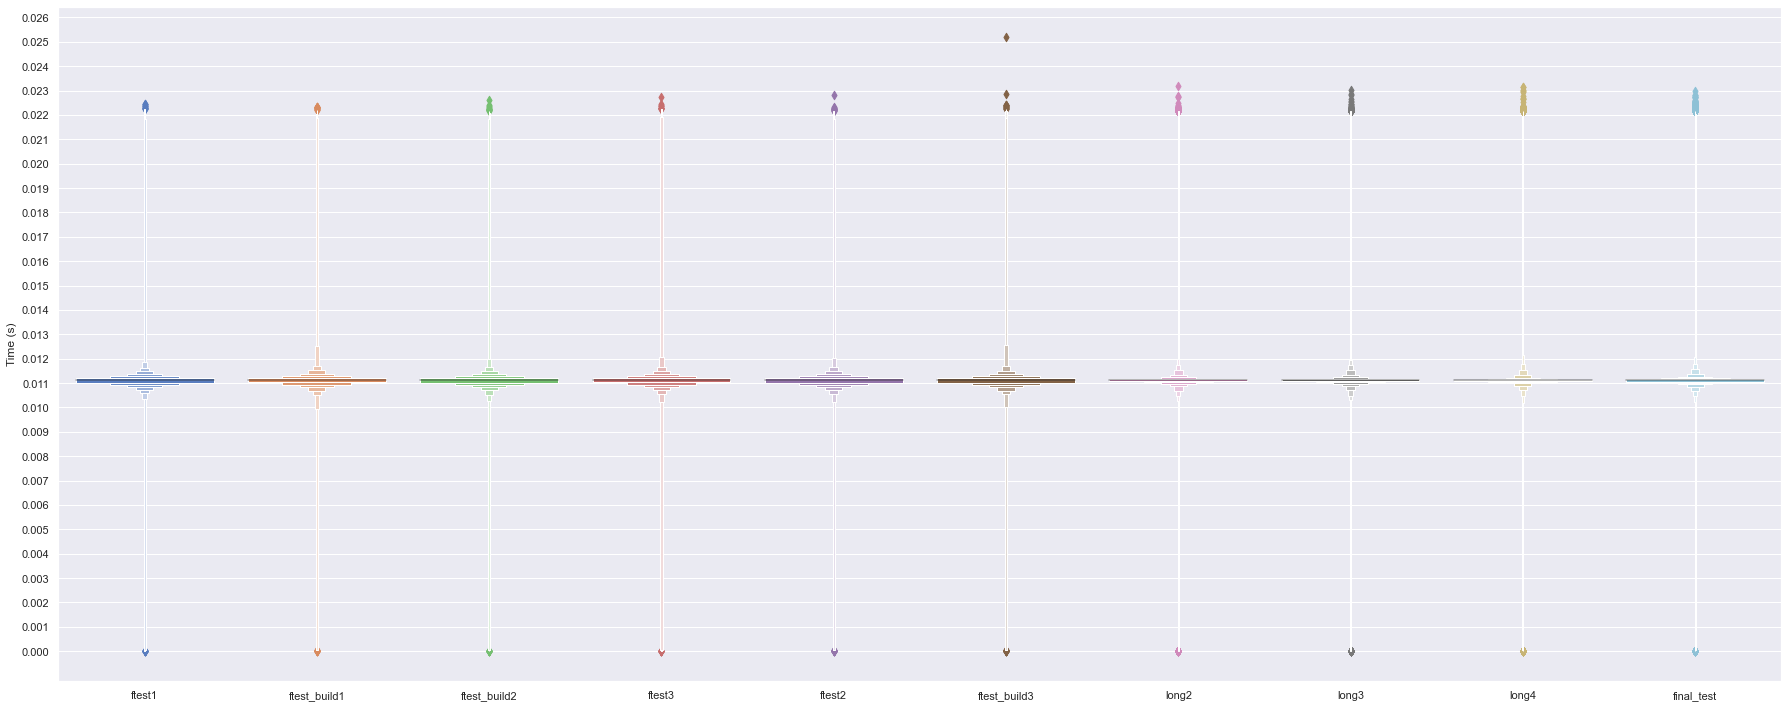

In [20]:
sns.set(rc={"figure.figsize": (25, 10)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style
g = sns.boxenplot(data=u_dist, palette="muted")
g.set_xticklabels(fnames)
g.set_yticks(np.arange(0, g.get_ylim()[1], 0.001))
plt.ticklabel_format(style="plain", axis="y", useOffset=False)
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()

## 6. Results
How constant are the framerates?

__Unity (90 FPS or sample ~ 11.11 ms)__

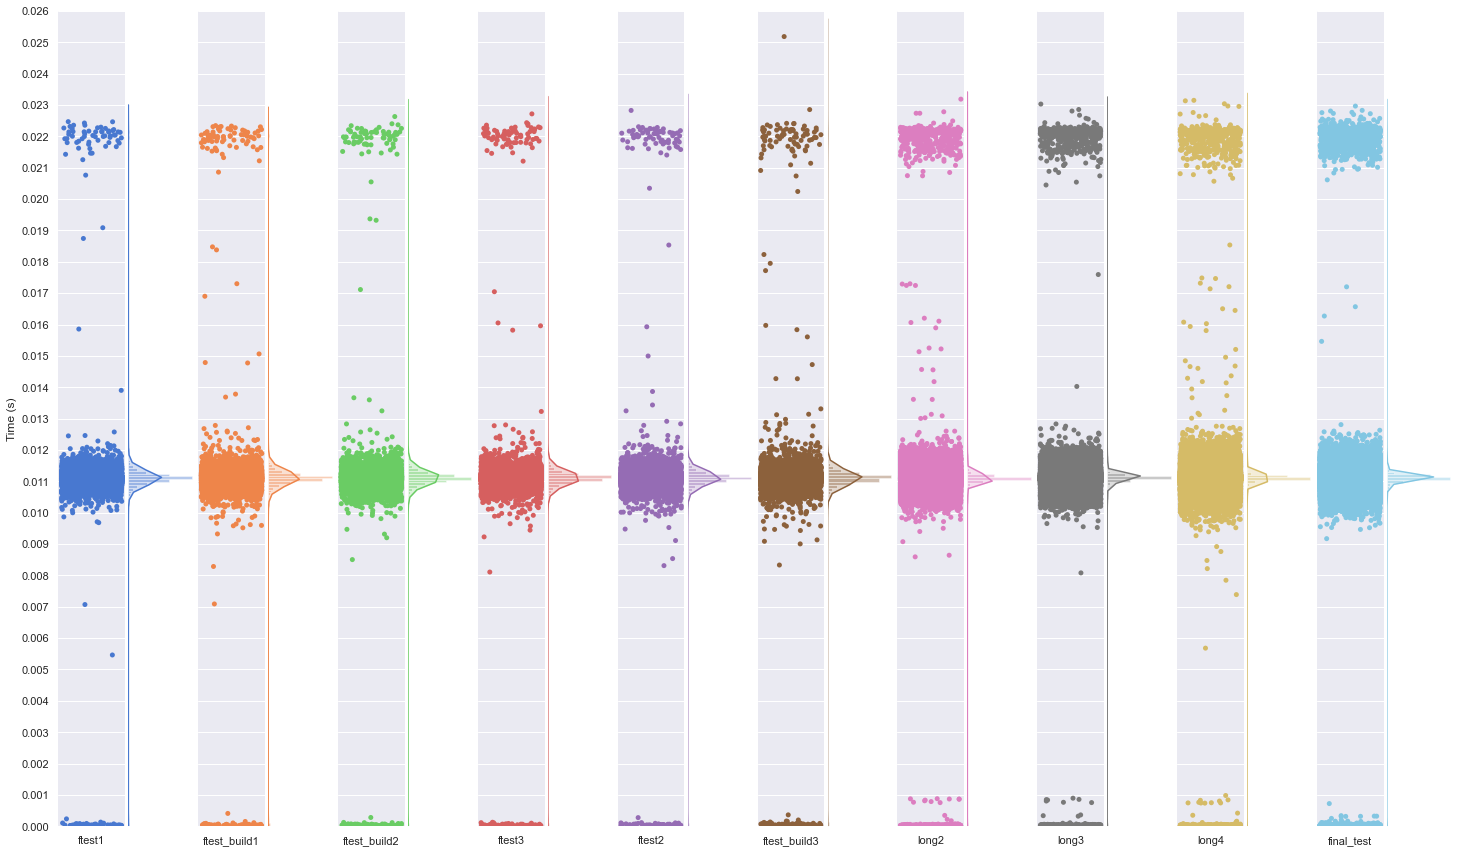

In [23]:
%matplotlib inline
nplots = len(u_dist) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
# since sharey does not work in this context by adding subplots one by one
for dist in u_dist:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)

step = 0.001
ticks = np.arange(0, y_max + step, step)
kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=u_dist[j], ax=ax, orient="v", color=color)
            ax.set_xticklabels([fnames[j]])  # filename
            ax.set_ylim(0, y_max)
            ax.set_yticks(ticks)
        else:
            sns.distplot(
                u_dist[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=250,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(0, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])


plt.subplots_adjust(wspace=0.05)

fig.axes[0].set_ylabel("Time (s)")
plt.show()

## 6. Results
How constant are the framerates?

__Unity (90 FPS or sample ~ 11.11 ms)__

In [24]:
odds = {}
odds["N"] = []
odds["N 0"] = []
odds["% 0"] = []
odds["N Middle"] = []
odds["% Middle"] = []
odds["N 2x"] = []
odds["% 2x"] = []
odds["N 2x -> 0"] = []
odds["% 2x -> 0"] = []
odds["N 0 -> 2x"] = []
odds["% 0 -> 2x"] = []

for k in recordings:
    zero = 0
    twice = 0
    taz = 0
    zat = 0
    middle = 0
    length = len(u_dist[k])
    odds["N"].append(length)
    for i in range(length):
        if u_dist[k][i] < 0.010:
            zero += 1
            if i > 1 and u_dist[k][i - 1] > 0.012:
                zat += 1
        elif u_dist[k][i] > 0.012:
            twice += 1
            if i > 1 and u_dist[k][i - 1] > 0.010:
                taz += 1
        else:
            middle += 1
    odds["N 0"].append(zero)
    odds["% 0"].append(zero * 100 / length)
    odds["N Middle"].append(middle)
    odds["% Middle"].append(middle * 100 / length)
    odds["N 2x"].append(twice)
    odds["% 2x"].append(twice * 100 / length)
    odds["N 2x -> 0"].append(taz)
    odds["% 2x -> 0"].append(taz * 100 / length)
    odds["N 0 -> 2x"].append(zat)
    odds["% 0 -> 2x"].append(zat * 100 / length)

odds = pd.DataFrame(odds, index=fnames)
display(odds)

,N,N 0,% 0,N Middle,% Middle,N 2x,% 2x,N 2x -> 0,% 2x -> 0,N 0 -> 2x,% 0 -> 2x
ftest1,10981,62,0.56461,10843,98.74328,76,0.69210,38,0.34605,25,0.22767
ftest_build1,11206,89,0.79422,11007,98.22417,110,0.98162,53,0.47296,41,0.36588
ftest_build2,12061,78,0.64671,11890,98.58221,93,0.77108,53,0.43943,38,0.31507
ftest3,12285,84,0.68376,12099,98.48596,102,0.83028,54,0.43956,36,0.29304
ftest2,12465,76,0.60971,12286,98.56398,103,0.82631,55,0.44124,33,0.26474
ftest_build3,13096,103,0.78650,12859,98.19029,134,1.02321,76,0.58033,62,0.47343
long2,162286,468,0.28838,161206,99.33451,612,0.37711,295,0.18178,152,0.09366
long3,166381,464,0.27888,165306,99.35389,611,0.36723,312,0.18752,168,0.10097
long4,192663,631,0.32751,191124,99.20120,908,0.47129,533,0.27665,253,0.13132
final_test,355351,1191,0.33516,352669,99.24525,1491,0.41959,673,0.18939,420,0.11819


## 6. Results
Peak detections

In [29]:
display(peaks_desc)

,maximum,u_color,% u_color,e_color,% e_color,u_audio,% u_audio,e_audio,% e_audio
ftest1,244,239,97.95082,237,99.16318,239,97.95082,239,100.00000
ftest_build1,250,244,97.60000,242,99.18033,244,97.60000,244,100.00000
ftest_build2,268,262,97.76119,258,98.47328,262,97.76119,262,100.00000
ftest3,273,268,98.16850,264,98.50746,268,98.16850,267,99.62687
ftest2,277,271,97.83394,268,98.89299,271,97.83394,271,100.00000
ftest_build3,290,286,98.62069,282,98.60140,286,98.62069,284,99.30070
long2,3606,3532,97.94786,3520,99.66025,3532,97.94786,3532,100.00000
long3,3696,3621,97.97078,3604,99.53052,3621,97.97078,3621,100.00000
long4,4280,4195,98.01402,4172,99.45173,4195,98.01402,4195,100.00000
final_test,7895,7748,98.13806,7706,99.45792,7747,98.12540,7744,99.96128


## 6. Results
Peak detections

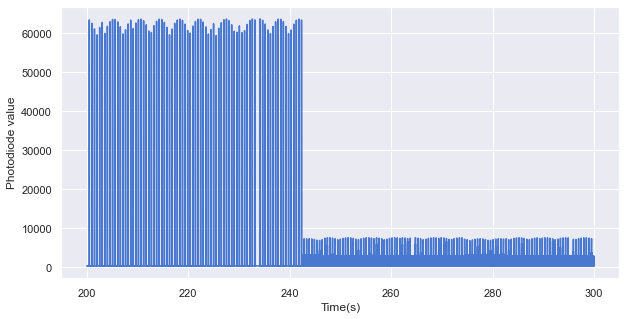

In [28]:
%matplotlib inline
palette = itertools.cycle(sns.color_palette(palette="muted"))
plt.figure(figsize=(10, 5))
sns.lineplot(
    x=recordings[8]["eeg"]["timestamps"][204800:307200],
    y=recordings[8]["eeg"]["color"][204800:307200],
    color=next(palette),
)
plt.ylabel("Photodiode value")
plt.xlabel("Time(s)")
plt.show()

## 6. Results
Latencies

__Time distance between unity color markers and the diode peaks__

In [30]:
display(c_stats.style.applymap(color_checks, subset=["AVG"]))

,ftest1,ftest_build1,ftest_build2,ftest3,ftest2,ftest_build3,long2,long3,long4,final_test,AVG
count,237.000000,242.000000,258.000000,264.000000,268.000000,282.000000,3520.000000,3604.000000,4172.000000,7706.000000,2055.300000
mean,0.075043,0.075053,0.075050,0.075026,0.075027,0.075070,0.073522,0.073504,0.075977,0.075361,0.074863
std,0.000495,0.000348,0.000543,0.000507,0.000383,0.000660,0.000365,0.000406,0.000406,0.000301,0.000441
min,0.073792,0.074127,0.073756,0.073762,0.072521,0.073900,0.062520,0.062223,0.064602,0.074084,0.070529
25%,0.074742,0.074797,0.074765,0.074752,0.074783,0.074765,0.073278,0.073266,0.075732,0.075118,0.074600
50%,0.075020,0.075041,0.075039,0.075005,0.075050,0.074964,0.073521,0.073511,0.075978,0.075364,0.074849
75%,0.075293,0.075276,0.075288,0.075263,0.075274,0.075275,0.073777,0.073758,0.076228,0.075610,0.075104
max,0.080321,0.076752,0.080420,0.079667,0.077808,0.080432,0.075394,0.077715,0.081206,0.075989,0.078570


## 6. Results
Latencies

__Time distance between unity color markers and the diode peaks__

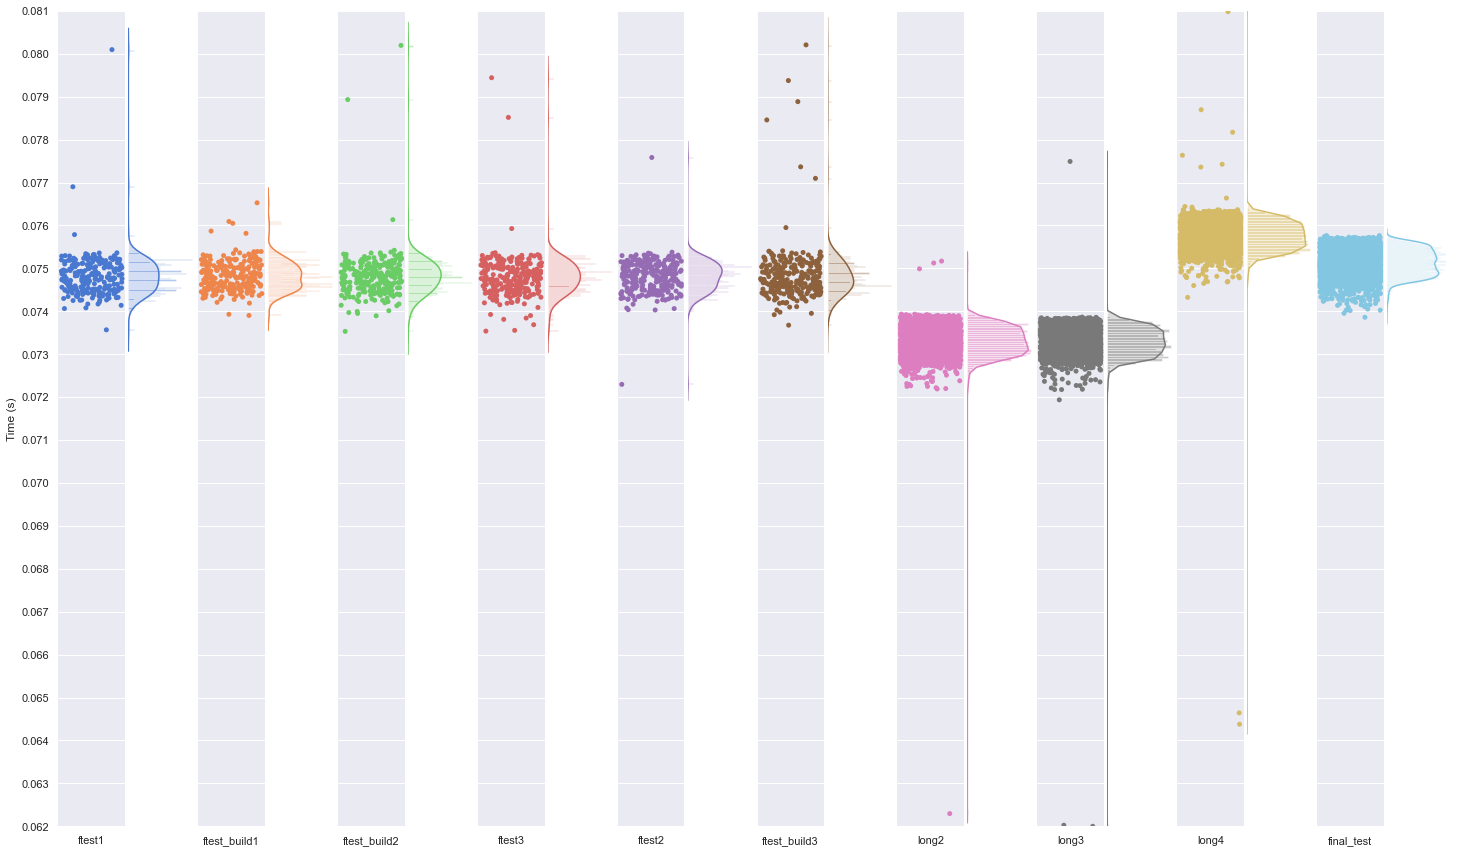

In [31]:
%matplotlib inline
nplots = len(c_diff_all) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
y_min = 1
# since sharey does not work in this context by adding subplots one by one
for dist in c_diff_all:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)
    if min(dist) < y_min:
        y_min = min(dist)

step = 0.001
ticks = np.arange(y_min, y_max + step, step)
kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=c_diff_all[j], ax=ax, orient="v", color=color)
            ax.set_xticklabels([fnames[j]])  # filename
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        else:
            sns.distplot(
                c_diff_all[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=250,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])


plt.subplots_adjust(wspace=0.05)

fig.axes[0].set_ylabel("Time (s)")
plt.show()

## 6. Results
Latencies

__Time distance between unity audio playing markers and microphone peaks__

In [32]:
display(a_stats.style.applymap(color_checks, subset=["AVG"]))

,ftest1,ftest_build1,ftest_build2,ftest3,ftest2,ftest_build3,long2,long3,long4,final_test,AVG
count,239.000000,244.000000,262.000000,267.000000,271.000000,284.000000,3532.000000,3621.000000,4195.000000,7744.000000,2065.900000
mean,0.144945,0.139820,0.138772,0.143700,0.145448,0.143370,0.139008,0.143943,0.139353,0.141953,0.142031
std,0.004377,0.004409,0.004587,0.006956,0.005367,0.004463,0.004401,0.004385,0.004341,0.005379,0.004866
min,0.124942,0.128778,0.127420,0.125329,0.126975,0.131950,0.125599,0.126703,0.125724,0.125079,0.126850
25%,0.141982,0.136593,0.135626,0.139428,0.141689,0.140020,0.135901,0.140924,0.136362,0.138423,0.138695
50%,0.145270,0.139689,0.138773,0.144235,0.145351,0.143312,0.139070,0.144048,0.139267,0.141960,0.142098
75%,0.148013,0.142652,0.141839,0.147746,0.148775,0.147163,0.142038,0.146843,0.142362,0.145502,0.145293
max,0.157813,0.152345,0.154999,0.171731,0.174338,0.155167,0.157790,0.164417,0.156623,0.173781,0.161900


## 6. Results
Latencies

__Time distance between unity audio playing markers and microphone peaks__

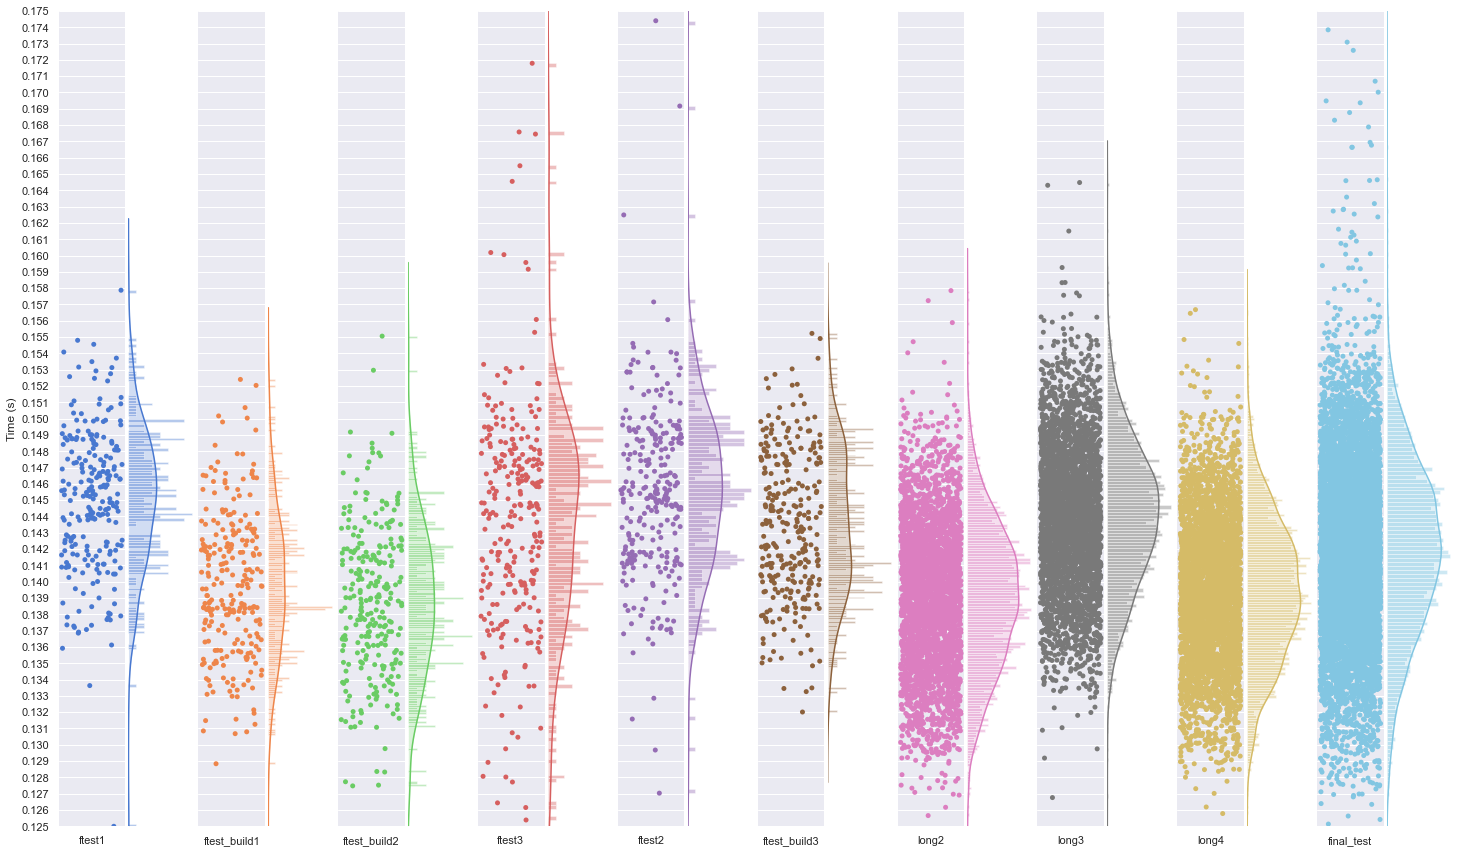

In [33]:
%matplotlib inline
nplots = len(c_diff_all) * 2  # number of subplots
palette = itertools.cycle(sns.color_palette(palette="muted"))

# define subplots
fig = plt.figure(figsize=(25, 15))
cols = 1
gs = fig.add_gridspec(cols, nplots)

y_max = 0
y_min = 1
# since sharey does not work in this context by adding subplots one by one
for dist in a_diff_all:  # get the maximum y value to set the same scale on subplots
    if max(dist) > y_max:
        y_max = max(dist)
    if min(dist) < y_min:
        y_min = min(dist)

step = 0.001
ticks = np.arange(y_min, y_max + step, step)
kde = {"shade": True}
j = 0
for i in range(nplots):
    style = "darkgrid" if i % 2 == 0 else "white"
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[i])
        if i % 2 == 0:
            color = next(palette)
            sns.stripplot(x=a_diff_all[j], ax=ax, orient="v", color=color)
            ax.set_xticklabels([fnames[j]])  # filename
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        else:
            sns.distplot(
                a_diff_all[j],
                ax=ax,
                vertical=True,
                norm_hist=True,
                bins=200,
                kde_kws=kde,
                color=color,
            )
            ax.set_ylim(y_min, y_max)
            ax.set_yticks(ticks)
            ax.set_xticklabels([])
            sns.despine(left=True, bottom=True)
            j += 1
        if i != 0:
            ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.05)
fig.axes[0].set_ylabel("Time (s)")
plt.show()

## 7. Conclusions and remarks
- LSL streams have normally "senseless" time differences when comparing starts and endings (<600ms). Not an indicator of a wrong recording.
- Stream time info values do not coincide with the recorded ones because dejittering is not taken into account. Not a bug.
- EEG framerate is extremely constant
- Unity framerate is (even in the simplest and lightest Unity project possible) not really constant
- Also Unity:
    - 1% of samples next to each other (<1ms) or twice the avg (~22ms)
    - Skips 1-2% of the triggers
- A better CPU on the recorder computer seems to contribute on a more precise aligning of streams
- No difference between: short and long recordings, different Unity builds
- Latency for video ~ 75 ms (std of 0.4 ms)
- Latency for audio ~ 105 ms (std of 4 ms)
- Using LSL for recording Unity and EEG data looks reliable

## 8. Future outlook

- New recordings and data analysis using a "heavy" Unity project
- Try very short click sounds for a better estimation of audio latency
- Clean the repos and comment the code for further use or easier reproducibility

## Resources

- [Liblsl](https://github.com/sccn/liblsl/releases)
- [LabRecorder](https://github.com/labstreaminglayer/App-LabRecorder/releases)
- [LSL4Unity](https://github.com/labstreaminglayer/LSL4Unity)
- [LSL Apps](https://github.com/sccn/labstreaminglayer/tree/master/Apps)
- [LSL documentation reference](https://labstreaminglayer.readthedocs.io/)
- [LSL latency analysis](https://github.com/mvidaldp/lsl_latency_analysis)
- [Unity latency project](https://github.com/mvidaldp/black_n_white)
- [Audio tones generator](https://github.com/mvidaldp/pytonegen)
